In [16]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB


%matplotlib inline

def review_to_words( raw_review ):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]   
    return( " ".join( meaningful_words ))   

train_df = pd.read_table('train.tsv')
test_df = pd.read_table('test.tsv')

test_df['Sentiment'] = -1 #a placeholder value, once we break up the test data into subsets, we can change this value
train_sentences = train_df.groupby('SentenceId').first().reset_index()
test_sentences = test_df.groupby('SentenceId').first().reset_index()
train_sentences["Phrase"] = train_sentences["Phrase"].apply(review_to_words)
test_sentences["Phrase"] = test_sentences["Phrase"].apply(review_to_words)

Accuracy 0.392437801424


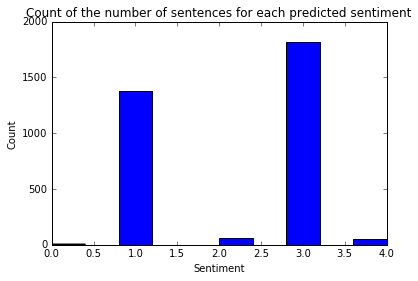

Sentiment:  0 Percentage:  0.00211480362538
Sentiment:  1 Percentage:  0.415709969789
Sentiment:  2 Percentage:  0.0190332326284
Sentiment:  3 Percentage:  0.548640483384
Sentiment:  4 Percentage:  0.014501510574


In [19]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_sentences.Phrase)

train_sentences_features = vectorizer.transform(train_sentences.Phrase)
test_sentences_features = vectorizer.transform(test_sentences.Phrase)

clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
scores = cross_validation.cross_val_score(clf, train_sentences_features, train_sentences["Sentiment"], cv=10)
print "Accuracy", scores.mean()

clf = clf.fit(train_sentences_features, train_sentences["Sentiment"])
result = clf.predict(test_sentences_features)
sentences = pd.DataFrame(data={"PhraseId":test_sentences["PhraseId"], "Sentiment":result})

plt.hist(sentences.Sentiment)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of the number of sentences for each predicted sentiment')
plt.show()
for i in range(0, 5):
    print "Sentiment: ", i, "Percentage: ", len(sentences[sentences.Sentiment == i]) / float(len(sentences))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


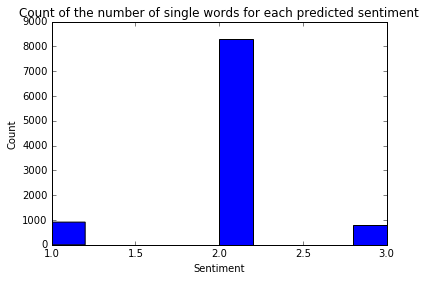

Sentiment:  0 Percentage:  0.0
Sentiment:  1 Percentage:  0.0913720790893
Sentiment:  2 Percentage:  0.830037946874
Sentiment:  3 Percentage:  0.0785899740363
Sentiment:  4 Percentage:  0.0


In [23]:
negWords = open("negative.txt").read().split("\n")
posWords = open("positive.txt").read().split("\n")

test_df["containsSpaces"] = test_df["Phrase"].apply(lambda x: ' ' in x)
test_sw = test_df[test_df.containsSpaces == False]

def get_sentiment_single_word(word):
    """Takes in as input a single word, checks if the word is in two text files we downloaded of negative and positive
    words, and returns the corresponding value. We use 1 and 3 instead of 0 and 4 because we assume no single word can
    have an extremely negative or positive sentiment."""
    if word in negWords:
        return 1
    elif word in posWords:
        return 3
    else:
        return 2
    
test_sw['Sentiment'] = test_sw['Phrase'].apply(get_sentiment_single_word)

sw = test_sw[['PhraseId', 'Sentiment']]

plt.hist(sw.Sentiment)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of the number of single words for each predicted sentiment')
plt.show()
for i in range(0, 5):
    print "Sentiment: ", i, "Percentage: ", len(sw[sw.Sentiment == i]) / float(len(sw))

merged1 = pd.merge(sentences, sw, how='outer')

In [25]:
remainingPhrases = test_df[~test_df['PhraseId'].isin(merged1['PhraseId'])].reset_index()
remainingPhrases["Phrase"] = remainingPhrases["Phrase"].apply(review_to_words)

sw_dict = test_sw.set_index('Phrase')['Sentiment'].to_dict()

def get_sentiment_phrase(phrase):
    phrase_sentiment = []
    for word in phrase.split():
        if word in sw_dict:
            phrase_sentiment.append(sw_dict[word])
        else:
            phrase_sentiment.append(2)
    if len(phrase_sentiment):
        return sum(phrase_sentiment)/len(phrase_sentiment)
    else:
        return 2

remainingPhrases['Sentiment'] = remainingPhrases['Phrase'].apply(get_sentiment_phrase)
phrases = remainingPhrases[['PhraseId', 'Sentiment']]
merged2 = pd.merge(merged1, phrases, how='outer')
print len(merged2)

66292


In [34]:
final = merged2.sort_values(by='PhraseId')
final['PhraseId'] = final['PhraseId'].apply(lambda x: int(x))
final['Sentiment'] = final['Sentiment'].apply(lambda x: int(x))
final.to_csv( "ZG_rotten_tomatoes_model1.csv", index=False, quoting=3 )

Kaggle score: 0.52572

In [36]:
baseline = merged2.sort_values(by='PhraseId')
baseline['PhraseId'] = final['PhraseId'].apply(lambda x: int(x))
baseline['Sentiment'] = final['Sentiment'].apply(lambda x: 2)
baseline.to_csv( "ZG_rotten_tomatoes_baseline.csv", index=False, quoting=3 )

Kaggle score: 0.51789